In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [3]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from copy import copy 
import itertools
import json
import argparse 

/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [5]:
is_jupyter = 'ipykernel' in sys.modules
if is_jupyter:
    num_objects = 2
    encoder_model='small7'
    seed = 44
    epochs = 50
    expand_dim_encoder = 0
    num_middle_encoder = 0
    train_variation = 'none'
    scale_factor = 1.5
    scale_lr = 5
    model_type = 'joint'
    noisy = False 
    weight_decay = 0.0004
    lr = 0.05
else:
    parser = argparse.ArgumentParser(description="Synthetic Dataset Experiments")


    parser.add_argument('--num_objects', type=int, default=2, help='Number of objects')
    parser.add_argument('--encoder_model', type=str, default='inceptionv3', help='Encoder model')
    parser.add_argument('--seed', type=int, default=42, help='Random seed')
    parser.add_argument('--epochs', type=int, default=50, help='Number of epochs')
    parser.add_argument('--expand_dim_encoder', type=int, default=0, help='For MLPs, size of the middle layer')
    parser.add_argument('--num_middle_encoder', type=int, default=0, help='For MLPs, number of middle layers')
    parser.add_argument('--train_variation', type=str, default='none', help='Either "none", "loss", or "half"')
    parser.add_argument('--scale_lr', type=int, default=5, help='For the half train variation, how much to decrease LR by')
    parser.add_argument('--scale_factor', type=float, default=1.5, help='For the loss train variation, how much to scale loss by')
    parser.add_argument('--model_type', type=str, default='joint', help='"joint" or "independent" model')
    parser.add_argument('--noisy', dest='noisy',default=False,action='store_true')
    parser.add_argument('--weight_decay', default=0.0004,type=float,help="What weight decay to use")
    parser.add_argument('--lr', type=float, default=0.05, help='Learning Rate')

    args = parser.parse_args()
    num_objects = args.num_objects
    encoder_model = args.encoder_model 
    seed = args.seed 
    epochs = args.epochs 
    expand_dim_encoder = args.expand_dim_encoder
    num_middle_encoder = args.num_middle_encoder
    train_variation = args.train_variation 
    scale_factor = args.scale_factor 
    scale_lr = args.scale_lr 
    model_type = args.model_type 
    noisy = args.noisy
    weight_decay = args.weight_decay 
    lr = args.lr 

if noisy:
    dataset_name = "synthetic_object/synthetic_{}_noisy".format(num_objects)
else:
    dataset_name = "synthetic_object/synthetic_{}".format(num_objects)

parameters = {
    'seed': seed, 
    'encoder_model': encoder_model ,
    'epochs': epochs, 
    'num_attributes': num_objects*2,
    'expand_dim_encoder': expand_dim_encoder, 
    'num_middle_encoder': num_middle_encoder, 
    'debugging': False,
    'dataset': dataset_name,
    'weight_decay': weight_decay, 
    'lr': lr, 
}

if train_variation != 'none':
    parameters['train_variation'] = train_variation 

    if train_variation == 'half':
        parameters['scale_lr'] = scale_lr 
    elif train_variation == 'loss':
        parameters['scale_factor'] = scale_factor 

parameters['model_type'] = model_type 

print(parameters)
torch.cuda.set_per_process_memory_fraction(0.5)



{'seed': 44, 'encoder_model': 'small7', 'epochs': 50, 'num_attributes': 4, 'expand_dim_encoder': 0, 'num_middle_encoder': 0, 'debugging': False, 'dataset': 'synthetic_object/synthetic_2', 'weight_decay': 0.0004, 'lr': 0.05, 'model_type': 'joint'}


In [6]:
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:
train_loader, val_loader, test_loader, train_pkl, val_pkl, test_pkl = get_data(num_objects,encoder_model=encoder_model,dataset_name=dataset_name)

In [8]:
test_images, test_y, test_c = unroll_data(test_loader)

In [9]:
log_folder = get_log_folder(dataset_name,parameters).split("/")[-1]
results_folder = "../../results/synthetic/{}".format(log_folder)
if not os.path.exists(results_folder): 
    os.makedirs(results_folder)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
joint_model = get_synthetic_model(dataset_name,parameters)

In [12]:
if model_type == 'independent':
    joint_model[0] = joint_model[0].to(device)
    joint_model[1] = joint_model[1].to(device)
else:
    joint_model = joint_model.to(device)

In [13]:
run_model_function = run_joint_model if model_type == 'joint' else run_independent_model

In [14]:
if encoder_model == 'mlp':
    for i in range(len(joint_model.first_model.linear_layers)):
        joint_model.first_model.linear_layers[i] = joint_model.first_model.linear_layers[i].to(device) 

## Plot the Dataset

In [15]:
dataset_directory = "../../../../datasets"

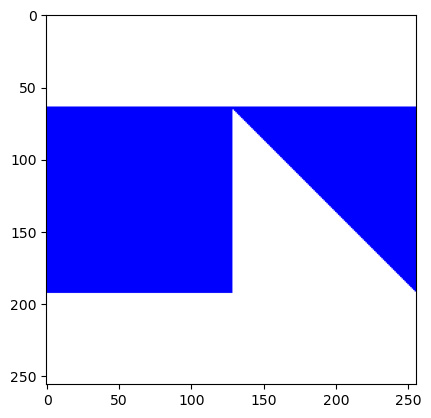

In [16]:
img_path = dataset_directory+'/'+train_pkl[0]['img_path']
image = Image.open(img_path)
plt.imshow(image)

## Analyze Accuracy

In [17]:
train_acc =  get_accuracy(joint_model,run_model_function,train_loader)
val_acc = get_accuracy(joint_model,run_model_function,val_loader)
test_acc =get_accuracy(joint_model,run_model_function,val_loader)

## Analyze Concept-Input Relationships

### Maximal Activation

In [18]:
def numpy_to_pil(img):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([2, 2, 2])

    unnormalized_image = img * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
    unnormalized_image = unnormalized_image*255 
    unnormalized_image = np.clip(unnormalized_image, 0, 255).astype(np.uint8) 
    im = Image.fromarray(unnormalized_image.transpose(1,2,0))
    return im

In [19]:
joint_model.to(device)

End2EndModel(
  (first_model): SimpleConvNetN(
    (conv_layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (all_fc): ModuleList(
      (0): FC(
        (fc): Linear(in_features=2048, out_features=1, bias=True)
      )
      (1): FC(
        (fc): Linear(in_features=2048, out_features=1, bias=True)
      )
      (2): FC(
        (fc): Linear(in_features=2048, out_features=1, bias=T

In [20]:
if is_jupyter:
    activation_values = []
    trials = 5
    lamb_values = [0,1,2,4,8,12,16]

    for lamb in lamb_values:
        print(lamb)
        val_for_concept = 0
        for concept_num in range(num_objects*2):
            for _ in range(trials):
                data_point = random.randint(0,len(test_images)-1)
                input_image = deepcopy(test_images[data_point:data_point+1])
                current_concept_val = test_c[data_point][concept_num]

                ret_image = get_maximal_activation(joint_model,run_model_function,concept_num,
                                                get_valid_image_function(concept_num,num_objects,epsilon=32),fixed_image=input_image,current_concept_val=current_concept_val,lamb=lamb).to(device)
                predicted_concept = torch.nn.Sigmoid()(run_model_function(joint_model,ret_image)[1].detach().cpu())[concept_num][0].detach().numpy()

                val_for_concept += abs(predicted_concept-current_concept_val.detach().numpy())/(trials*num_objects*2)
        
            if concept_num == 0:
                ret_image = ret_image.detach()[0].cpu().numpy()
                im = numpy_to_pil(ret_image)
                im.save("../../results/synthetic/l2_norm/example_{}_{}.png".format(lamb,seed)) 
        print(float(val_for_concept))
        activation_values.append(float(val_for_concept))
    json.dump({'activation_values': activation_values, 'lambda': lamb_values, 'parameters': parameters},open("../../results/synthetic/l2_norm/results_{}.json".format(seed),'w'))

0
1.0000000000000002
1
1.0000000000000002
2
1.0000000000000002
4
0.8000000000000002
8
0.35
12
0.5499999999999999
16
0.2


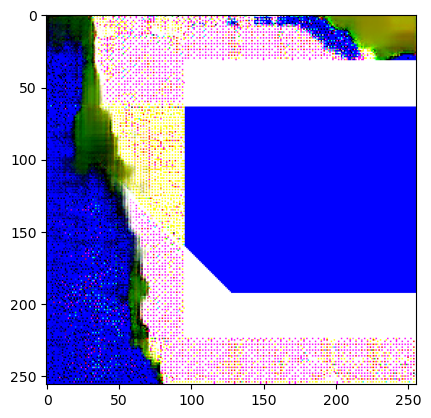

In [21]:
activation_values = []

for concept_num in range(num_objects*2):
    val_for_concept = 0
    trials = 5

    for _ in range(trials):
        data_point = random.randint(0,len(test_images)-1)
        input_image = deepcopy(test_images[data_point:data_point+1])
        current_concept_val = test_c[data_point][concept_num]

        ret_image = get_maximal_activation(joint_model,run_model_function,concept_num,
                                        get_valid_image_function(concept_num,num_objects,epsilon=32),fixed_image=input_image,current_concept_val=current_concept_val).to(device)
        predicted_concept = torch.nn.Sigmoid()(run_model_function(joint_model,ret_image)[1].detach().cpu())[concept_num][0].detach().numpy()
        
        val_for_concept += abs(predicted_concept-current_concept_val.detach().numpy())/trials 
        ret_image = ret_image.detach()[0].cpu().numpy()
        im = numpy_to_pil(ret_image) 
        plt.imshow(im)
        im.save("{}/{}.png".format(results_folder,"adversarial_{}".format(concept_num)))
    activation_values.append(val_for_concept)


In [22]:
if model_type == 'independent':
    joint_model[0] = joint_model[0].cpu()
    joint_model[1] = joint_model[1].cpu() 
else: 
    joint_model = joint_model.cpu()
torch.cuda.empty_cache()

## Analyze Saliency Maps

gradcam
integrated_gradients


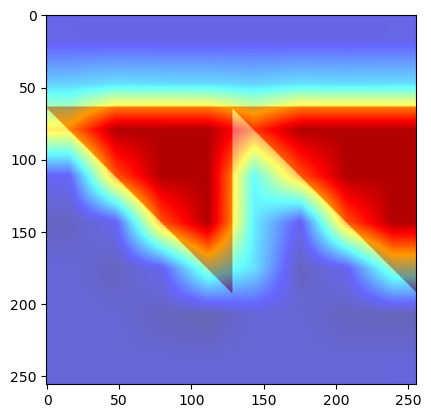

<Figure size 640x480 with 0 Axes>

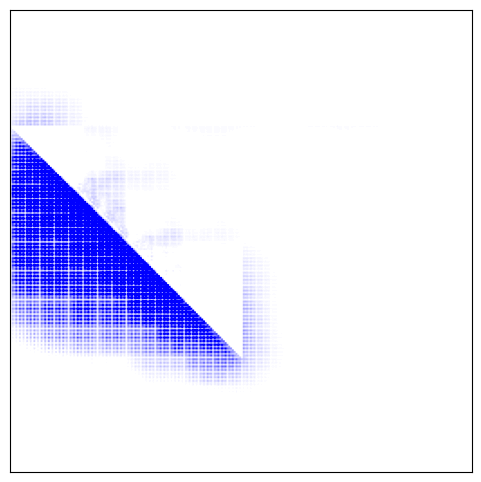

saliency


<Figure size 640x480 with 0 Axes>

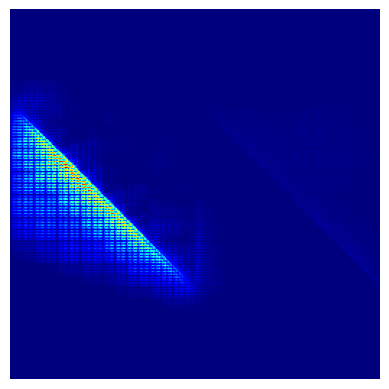

In [84]:
if is_jupyter:
    for method, method_name in zip(
        [plot_gradcam,plot_integrated_gradients,plot_saliency],
        ['gradcam','integrated_gradients','saliency']
    ):
        print(method_name)
        plt.figure()
        ret = method(joint_model,run_joint_model,0,test_images,0,test_pkl,plot=True)
        plt.savefig("../../results/explanations/{}_{}_synthetic_2.png".format(method_name,encoder_model))
        torch.cuda.empty_cache()


In [66]:
final_data = {
    'train_accuracy': train_acc, 
    'val_accuracy': val_acc, 
    'test_accuracy': test_acc, 
    'adversarial_activations': np.array(activation_values).tolist(),  
    'parameters': parameters, 
    'run_name': log_folder,
}

In [67]:
final_data 

{'train_accuracy': 1.0,
 'val_accuracy': 1.0,
 'test_accuracy': 1.0,
 'concept_accuracy': [1.0, 1.0, 1.0, 1.0],
 'adversarial_activations': [1.0, 1.0, 1.0, 1.0],
 'parameters': {'seed': 42,
  'encoder_model': 'small7',
  'epochs': 50,
  'num_attributes': 4,
  'expand_dim_encoder': 0,
  'num_middle_encoder': 0,
  'debugging': False,
  'dataset': 'synthetic_object/synthetic_2',
  'model_type': 'joint'},
 'run_name': 'b91127f2'}

In [27]:
json.dump(final_data,open("{}/results.json".format(results_folder),"w"))